In [1]:
using DrWatson

In [2]:
@quickactivate "RxInferThesisExperiments"

In [3]:
using RxInferThesisExperiments, Plots, PGFPlotsX, LaTeXStrings
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates, DataFrames

import RxInfer, ReactiveMP, ForneyLab, Turing

In [4]:
pgfplotsx()

# gr()

Plots.PGFPlotsXBackend()

In [5]:
const outfolder = plotsdir("nlds", "common")

"/Users/bvdmitri/.julia/dev/thesis/plots/nlds/common"

In [6]:
mkpath(outfolder);

In [7]:
function analyze_benchmarks(filterfunction, bfolder)
    benchmarks = prepare_benchmarks_table(bfolder);

    # Select only a portion of benchmarks for plotting
    filtered = filter(filterfunction, benchmarks)

    sorted = sort(filtered, [ :T ])

    # RxInfer includes the model creation time in it
    inference = getindex.(sorted.inference, 1) .- getindex.(sorted.inference, 3)
    creation  = getindex.(sorted.creation, 1) .- getindex.(sorted.creation, 3)

    min_timing_range = min(minimum(inference), minimum(creation))
    max_timing_range = max(maximum(inference), maximum(creation))

    return sorted, (inference, creation), (min_timing_range, max_timing_range)
end

analyze_benchmarks (generic function with 1 method)

In [8]:
target_seed = 42
target_niterations = 3
target_nsamples = 100

100

In [9]:
rxifb, (rxi_inference, rxi_creation), (rxi_min_tr, rxi_max_tr) = analyze_benchmarks(datadir("nlds", "rxinfer")) do r
    return r["niterations"] == target_niterations && r["seed"] == target_seed
end

[ Info: Scanning folder /Users/bvdmitri/.julia/dev/thesis/data/nlds/rxinfer for result files.
[ Info: Added 22 entries.


(13×7 DataFrame
 Row │ T       niterations  seed    amse       emse       inference            ⋯
     │ Int64?  Int64?       Int64?  Float64?   Float64?   Tuple…?              ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     10            3      42   8.09207    7.10241   (1.03787e6, 1.415e6, ⋯
   2 │     20            3      42  11.087     12.1779    (1.90448e6, 2.82422e
   3 │     30            3      42   9.23672    6.52359   (2.99427e6, 3.87393e
   4 │     50            3      42   7.23313    3.52385   (5.79057e6, 8.01622e
   5 │    100            3      42   4.16954    1.28988   (1.27809e7, 2.01602e ⋯
   6 │    200            3      42   0.84366    0.617622  (2.97711e7, 4.23667e
   7 │    300            3      42   1.39847    0.480039  (6.38084e7, 7.33319e
   8 │    500            3      42   0.367731   0.41845   (9.64137e7, 1.10284e
   9 │   1000            3      42   0.403539   0.324854  (1.90928e8, 2.39484e ⋯
  10 │   2000           

In [14]:
flfb, (fl_inference, fl_creation), (fl_min_tr, fl_max_tr) = analyze_benchmarks(datadir("nlds", "forneylab")) do r
    return r["niterations"] == target_niterations && r["seed"] == target_seed
end

[ Info: Scanning folder /Users/bvdmitri/.julia/dev/thesis/data/nlds/forneylab for result files.
[ Info: Added 8 entries.


(5×7 DataFrame
 Row │ T       niterations  seed    amse      emse      inference              ⋯
     │ Int64?  Int64?       Int64?  Float64?  Float64?  Tuple…?                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     10            3      42   8.09207   7.10241  (1.14833e6, 1.55756e6, ⋯
   2 │     20            3      42  11.087    12.1779   (2.70781e6, 3.52697e6,
   3 │     30            3      42   9.23668   6.52354  (3.62542e6, 4.71653e6,
   4 │     50            3      42   7.23535   3.53501  (5.97635e6, 8.76036e6,
   5 │    100            3      42   4.16957   1.28983  (1.36045e7, 1.66293e7, ⋯
                                                               2 columns omitted, ([1.148334e6, 2.707808e6, 3.625415e6, 5.976353e6, 1.3604546e7], [5.100003094e9, 1.0929191537e10, 1.5898139967e10, 2.7344669115e10, 5.1074718032e10]), (1.148334e6, 5.1074718032e10))

In [18]:
tgfb, (tg_inference, tg_creation), (tg_min_tr, tg_max_tr) = analyze_benchmarks(datadir("nlds", "turing", "nuts")) do r
    return r["nsamples"] == target_nsamples && r["seed"] == target_seed
end

[ Info: Scanning folder /Users/bvdmitri/.julia/dev/thesis/data/nlds/turing/nuts for result files.
[ Info: Added 6 entries.


(3×7 DataFrame
 Row │ T       nsamples  seed    amse      emse      inference                 ⋯
     │ Int64?  Int64?    Int64?  Float64?  Float64?  Tuple…?                   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     10       100      42   5.71171   4.92248  (1.13747e10, 1.13747e10,  ⋯
   2 │     20       100      42   3.69172   8.02788  (2.1521e10, 2.1521e10, 1.
   3 │     30       100      42  24.3499    6.32423  (4.01462e10, 4.01462e10,
                                                               2 columns omitted, ([1.1237186986e10, 2.1346839126e10, 3.9902297427e10], [3.291, 3.291, 3.292]), (3.291, 3.9902297427e10))

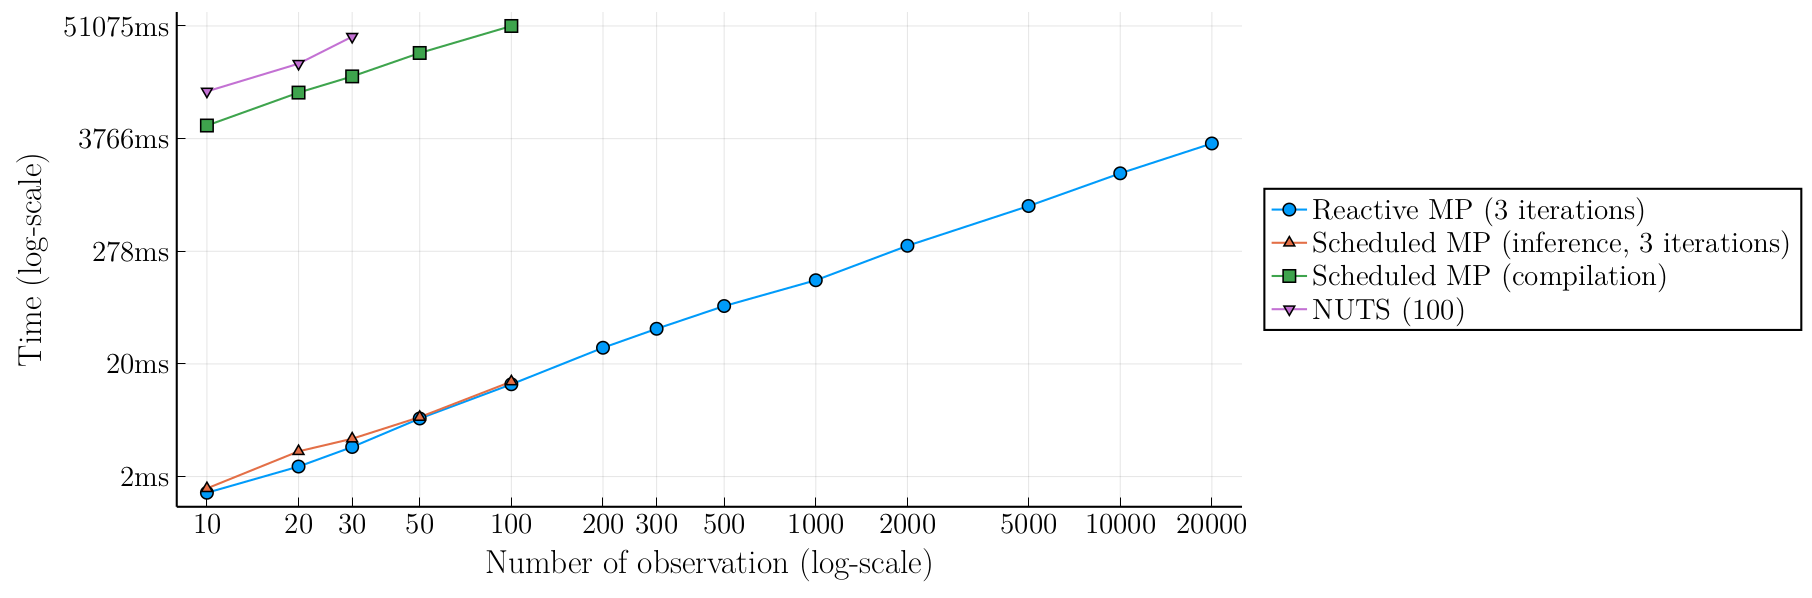

In [19]:
min_timing_range = min(rxi_min_tr, fl_min_tr, tg_min_tr)
max_timing_range = max(rxi_max_tr, fl_max_tr, tg_max_tr)

timing_range = exp.(range(log(min_timing_range), log(max_timing_range); length = 10))
sizes_range = sort(collect(union(rxifb.T, flfb.T, tgfb.T)))

yticks = (timing_range, replace.(to_ms_str.(timing_range; digits = 0), ".0" => ""))
xticks = (sizes_range, string.(sizes_range))

pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend_font_halign = :left
)

p = plot(
    size = (800, 400),
    yscale = :log10, xscale = :log10, yticks = yticks, xticks = xticks, 
    ylabel = "Time (log-scale)", xlabel = "Number of observation (log-scale)",
    legend = :outerright;
    pfontsettings...
)

p = plot!(p, rxifb.T, rxi_inference, label = "Reactive MP ($(target_niterations) iterations)", marker = :circle)
p = plot!(p, flfb.T, fl_inference, label = "Scheduled MP (inference, $(target_niterations) iterations)", marker = :utriangle)
p = plot!(p, flfb.T, fl_creation, label = "Scheduled MP (compilation)", marker = :rect)
p = plot!(p, tgfb.T, tg_inference, label = "NUTS ($target_nsamples)", marker = :dtriangle)